# **Historical style generator**

#### **Students – Leor Ariel Rose, Yahav Bar David**

#### **Academic advisor - Dr. Irina Rabaev**

This notebook contains our document style tranfer model and the explanations of the model.

Imports

In [ ]:
import math
import cv2
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.preprocessing import minmax_scale
from skimage.draw import rectangle, rectangle_perimeter
from google.colab.patches import cv2_imshow

In [ ]:
def open_img_grayscale(path: str) -> np.ndarray:
  """
  """
  img: np.ndarray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise IOError(f"Unable to open image {path}, please check path.")
  return img

def otso_threshold(img: np.ndarray) -> np.ndarray:
  """
  """
  # gaussian blur for better threshold
  img_blur: np.ndarray = cv2.GaussianBlur(img,(5,5),0)
  # threshold image
  return cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

def img_distance_transform(img: np.ndarray) -> np.ndarray:
  """
  """
  return cv2.distanceTransform(img, cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)

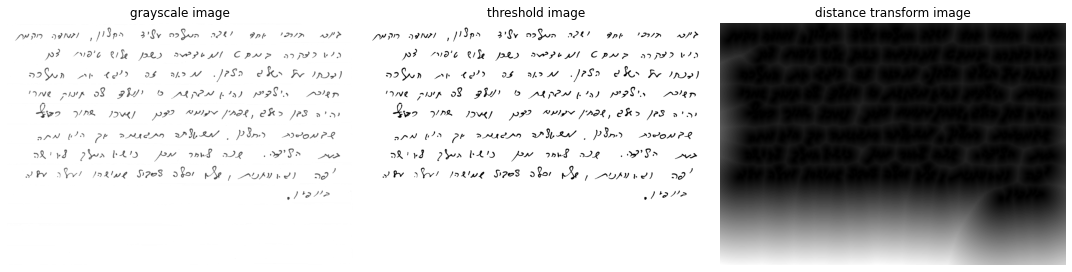

In [ ]:
# open image as grayscale
img_grayscale: np.ndarray = open_img_grayscale('1.png')

# threshold image
threshold_img: np.ndarray = otso_threshold(img_grayscale)

# distance transform image
dist_transform: np.ndarray = img_distance_transform(threshold_img)

# show images
f, axarr = plt.subplots(1, 3, figsize=(15,15))
axarr[0].imshow(img_grayscale, cmap='gray')
axarr[0].set_title('grayscale image')
axarr[0].axis('off')
axarr[1].imshow(threshold_img, cmap='gray')
axarr[1].set_title('threshold image')
axarr[1].axis('off')
axarr[2].imshow(dist_transform, cmap='gray')
axarr[2].set_title('distance transform image')
axarr[2].axis('off')
f.tight_layout()
plt.show()

Next step is to calculate the probaiblty for invertion for each pixel:

In [ ]:
def probaiblty_of_invertion(foreground: np.ndarray, background: np.ndarray,
                            distances: np.ndarray) -> np.ndarray:
  """
  """
  # probabilty for background pixel to inverse (from 0 to 255)
  p_bf = np.vectorize(lambda d: (1 * math.exp(-1 * 2 * (d ** 2)) + 5))
  # probabilty for foreground pixel to inverse (from 255 to 0)
  p_fb = np.vectorize(lambda d: (1 * math.exp(-1 * 2 * (d ** 2)) + 5))
  # create array with size of image
  prob = np.zeros(dist_transform.shape, dtype=np.float32)
  # calculate probabilty for background pixel to inverse
  prob[background] = p_bf(distances[background])
  # calculate probabilty for foreground pixel to inverse
  prob[foreground] = p_fb(distances[foreground])
  return prob

In [ ]:
# get foreground of grayscale image
foreground: np.ndarray = threshold_img == 0
# get background of grayscale image
background: np.ndarray = threshold_img == 255
# get image pixels probaiblty of invertion
prob: np.ndarray = probaiblty_of_invertion(foreground, background,
                                           minmax_scale(dist_transform))
# show probabilities distribution
np.histogram(prob)

(array([ 507468,  385881,  328216,  296855,  280728,  276820,  285168,
         312490,  463226, 8063148]),
 array([5.1353354, 5.2218018, 5.3082685, 5.394735 , 5.481201 , 5.567668 ,
        5.6541343, 5.7406006, 5.827067 , 5.9135337, 6.       ],
       dtype=float32))

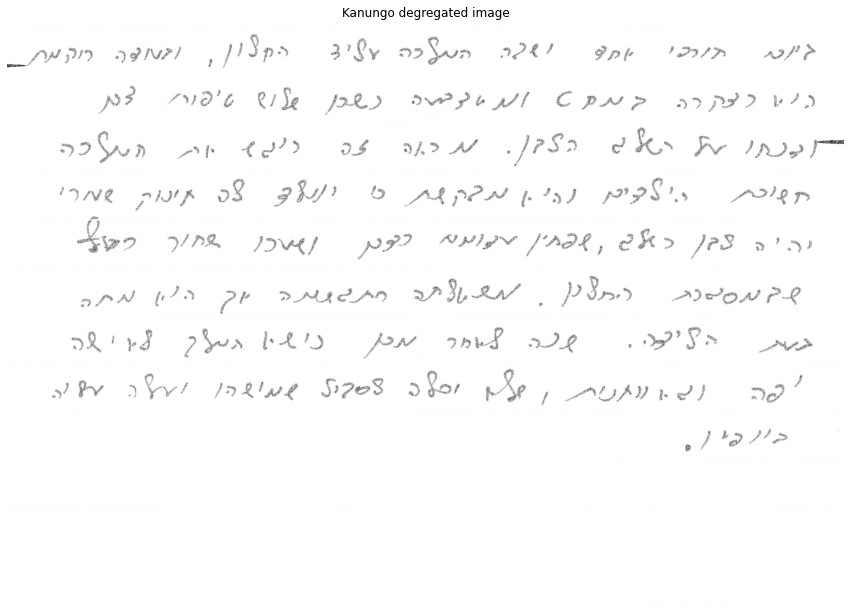

In [ ]:
# get all pixels that are seeds to change
pixels_to_change = prob >= np.max(prob)

# get all foreground pixels that are seeds to change
pixels_to_change_foreground = np.logical_and(foreground, pixels_to_change)
# get a random true false array of images size
random_choice = np.random.choice([False, True], img_grayscale.shape)
# change all true values in random array if they are false values 
# of foreground seeds (we want to choose only from seeds)
random_choice[np.logical_not(pixels_to_change_foreground)] = False
# get random seeds
random_pixels_to_change_foreground = np.logical_and(pixels_to_change_foreground, random_choice)

# get all background pixels that are seeds to change
pixels_to_change_background = np.logical_and(background, pixels_to_change)
# get a random true false array of images size
random_choice = np.random.choice([False, True], img_grayscale.shape)
# change all true values in random array if they are false values 
# of background seeds (we want to choose only from seeds)
random_choice[np.logical_not(pixels_to_change_background)] = False
# get random seeds
random_pixels_to_change_background = np.logical_and(pixels_to_change_background, random_choice)

# copy grayscale image
degregated_img = deepcopy(img_grayscale)
# change seeds of foreground to background
degregated_img[random_pixels_to_change_foreground] = 255
# change seeds of background to foreground
degregated_img[random_pixels_to_change_background] = 0
# apply morphological closing
degregated_img = cv2.morphologyEx(degregated_img, cv2.MORPH_OPEN, (5,5))
# show degregated image
plt.figure(figsize=(15,15))
plt.imshow(degregated_img, cmap="gray")
plt.title("Kanungo degregated image")
plt.axis("off")
plt.show()

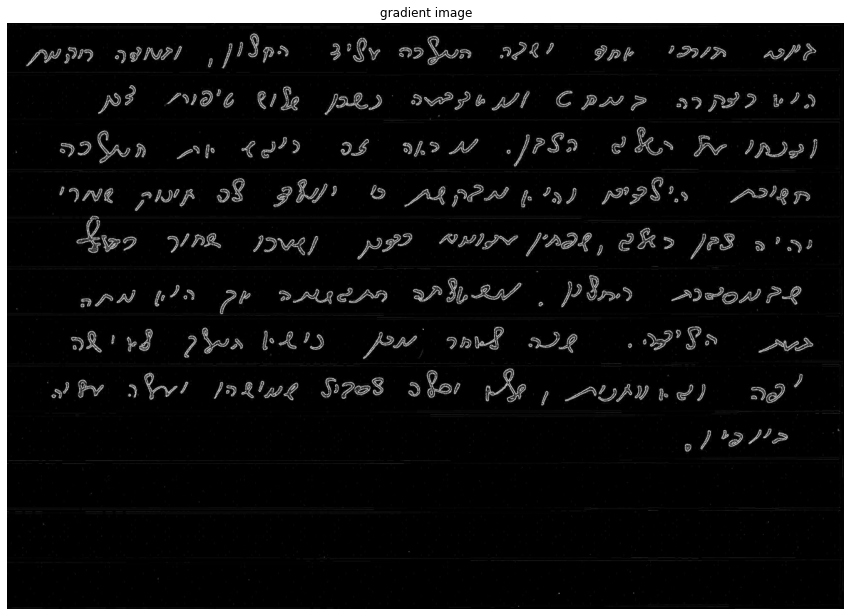

In [ ]:
sobel_x: np.ndarray = cv2.Sobel(img_grayscale, cv2.CV_64F, 1, 0)
sobel_y: np.ndarray = cv2.Sobel(img_grayscale, cv2.CV_64F, 0, 1)
sobel_x: np.ndarray = np.uint8(np.absolute(sobel_x))
sobel_y: np.ndarray = np.uint8(np.absolute(sobel_y))
sobel_combined: np.ndarray = cv2.bitwise_or(sobel_x, sobel_y)
plt.figure(figsize=(15,15))
plt.imshow(sobel_combined, cmap="gray")
plt.title("gradient image")
plt.axis("off")
plt.show()

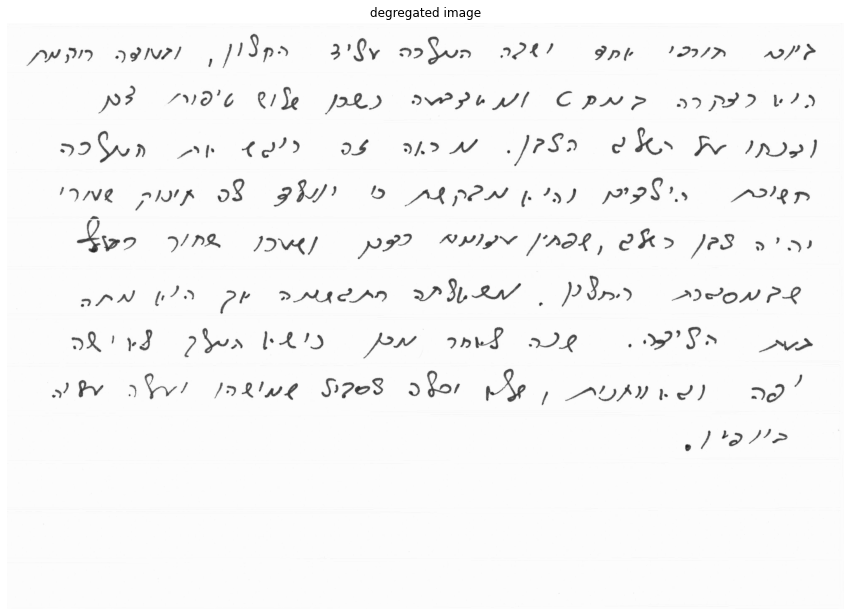

In [ ]:
def apply_noise(grayscale_img: np.ndarray, gradient_img: np.ndarray, foreground_seeds: np.ndarray, background_seeds: np.ndarray) -> np.ndarray:
  # parameter controlling the size of the noise regions
  a_0 = 5
  max_gradient_val = np.max(gradient_img)

  # probabilty for background pixel to inverse (from 0 to 255)
  a = np.vectorize(lambda pixel_gradient_val: round(a_0 * (1 + (pixel_gradient_val / max_gradient_val))))
  # create array with size of image
  rec_size = np.zeros(dist_transform.shape, dtype=np.float32)
  # calculate background seed rectangle size for degragation
  rec_size[background_seeds] = a(gradient_img[background_seeds])
  # calculate foreground seed rectangle size for degragation
  rec_size[foreground_seeds] = a(gradient_img[foreground_seeds])

  x_index, y_index= np.where(rec_size > 0)
  for i, j in zip(x_index, y_index):
    grayscale_img = apply_noise_to_seed(grayscale_img, (i,j), rec_size[i, j])
  return grayscale_img

def apply_noise_to_seed(grayscale_img: np.ndarray, seed_index, size):
  rr, cc = rectangle(seed_index, extent=(int(size),int(size)), shape=grayscale_img.shape)
  rr_2, cc_2 = rectangle_perimeter(start, end=end, shape=img.shape)
  gaussian_noise = np.random.normal(np.random.random_sample(), 0.6, grayscale_img[rr, cc].shape)
  grayscale_img[rr, cc] += gaussian_noise
  return grayscale_img

degregated_img = apply_noise(deepcopy(img_grayscale.astype('float32')), sobel_combined, random_pixels_to_change_foreground, random_pixels_to_change_background)
plt.figure(figsize=(15,15))
plt.imshow(degregated_img, cmap="gray")
plt.title("degregated image")
plt.axis("off")
plt.show()